In [1]:
import numpy as np
import pandas as pd
import data_clean_utils
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split
import joblib

In [2]:
import dagshub
dagshub.init(repo_owner='Ranjeet-Kumar60', repo_name='swiggy-delivery-time-prediction1', mlflow=True)

Accessing as Ranjeet-Kumar60

Initialized MLflow to track repo "Ranjeet-Kumar60/swiggy-delivery-time-prediction1"

Repository Ranjeet-Kumar60/swiggy-delivery-time-prediction1 initialized!

In [3]:
import mlflow

In [4]:
# set the tracking server

mlflow.set_tracking_uri("https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow")

In [5]:
# mlflow experiment

mlflow.set_experiment("Exp 4 - LGBM Hyperparameters Tuning")

2025/10/01 10:21:35 INFO mlflow.tracking.fluent: Experiment with name 'Exp 4 - LGBM Hyperparameters Tuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/67ddd96cadcf4b408ac16e7f77ed389a', creation_time=1759339296422, experiment_id='19', last_update_time=1759339296422, lifecycle_stage='active', name='Exp 4 - LGBM Hyperparameters Tuning', tags={}>

In [6]:
from sklearn import set_config

set_config(transform_output="pandas")

# Load the Data

In [7]:
df = pd.read_csv("../data/raw/swiggy.csv")
df

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,0x7c09,JAPRES04DEL01,30,4.8,26.902328,75.794257,26.912328,75.804257,24-03-2022,11:35:00,11:45:00,conditions Windy,High,1,Meal,motorcycle,0,No,Metropolitian,(min) 32
45589,0xd641,AGRRES16DEL01,21,4.6,0.000000,0.000000,0.070000,0.070000,16-02-2022,19:55:00,20:10:00,conditions Windy,Jam,0,Buffet,motorcycle,1,No,Metropolitian,(min) 36
45590,0x4f8d,CHENRES08DEL03,30,4.9,13.022394,80.242439,13.052394,80.272439,11-03-2022,23:50:00,00:05:00,conditions Cloudy,Low,1,Drinks,scooter,0,No,Metropolitian,(min) 16
45591,0x5eee,COIMBRES11DEL01,20,4.7,11.001753,76.986241,11.041753,77.026241,07-03-2022,13:35:00,13:40:00,conditions Cloudy,High,0,Snack,motorcycle,1,No,Metropolitian,(min) 26


# Clean Data

In [8]:
swiggy_cleaned=data_clean_utils.perform_data_cleaning(df)

In [9]:
swiggy_cleaned

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,city_name,order_day,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day,distance,distance_type
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,sunny,high,...,INDO,19,3,saturday,1,15.0,11.0,morning,3.025149,short
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,stormy,jam,...,BANG,25,3,friday,0,5.0,19.0,evening,20.183530,very_long
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,sandstorms,low,...,BANG,19,3,saturday,1,15.0,8.0,morning,1.552758,short
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,sunny,medium,...,COIMB,5,4,tuesday,0,10.0,18.0,evening,7.790401,medium
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,cloudy,high,...,CHEN,26,3,saturday,1,15.0,13.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,JAPRES04DEL01,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,windy,high,...,JAP,24,3,thursday,0,10.0,11.0,morning,1.489846,short
45589,AGRRES16DEL01,21.0,4.6,NaN,NaN,NaN,NaN,2022-02-16,windy,jam,...,AGR,16,2,wednesday,0,15.0,19.0,evening,NaN,NaN
45590,CHENRES08DEL03,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,cloudy,low,...,CHEN,11,3,friday,0,15.0,23.0,night,4.657195,short
45591,COIMBRES11DEL01,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,cloudy,high,...,COIMB,7,3,monday,0,5.0,13.0,afternoon,6.232393,medium


In [10]:
swiggy_cleaned.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'city_name', 'order_day', 'order_month',
       'order_day_of_week', 'is_weekend', 'pickup_time_minutes',
       'order_time_hour', 'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

In [11]:
# drop columns not required for model input

columns_to_drop =  ['rider_id',
                    'restaurant_latitude',
                    'restaurant_longitude',
                    'delivery_latitude',
                    'delivery_longitude',
                    'order_date',
                    "order_time_hour",
                    "order_day",
                    "city_name",
                    "order_day_of_week",
                    "order_month"]

swiggy_cleaned.drop(columns=columns_to_drop, inplace=True)

swiggy_cleaned

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,32,0,10.0,morning,1.489846,short
45589,21.0,4.6,windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,36,0,15.0,evening,NaN,NaN
45590,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,16,0,15.0,night,4.657195,short
45591,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26,0,5.0,afternoon,6.232393,medium


In [12]:
# check for missing values

swiggy_cleaned.isna().sum()

age                    1854
ratings                1908
weather                 525
traffic                 510
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     993
festival                228
city_type              1198
time_taken                0
is_weekend                0
pickup_time_minutes    1640
order_time_of_day      2070
distance               3630
distance_type          3630
dtype: int64

In [13]:
# check for duplicates

swiggy_cleaned.duplicated().sum()

np.int64(0)

<Axes: >

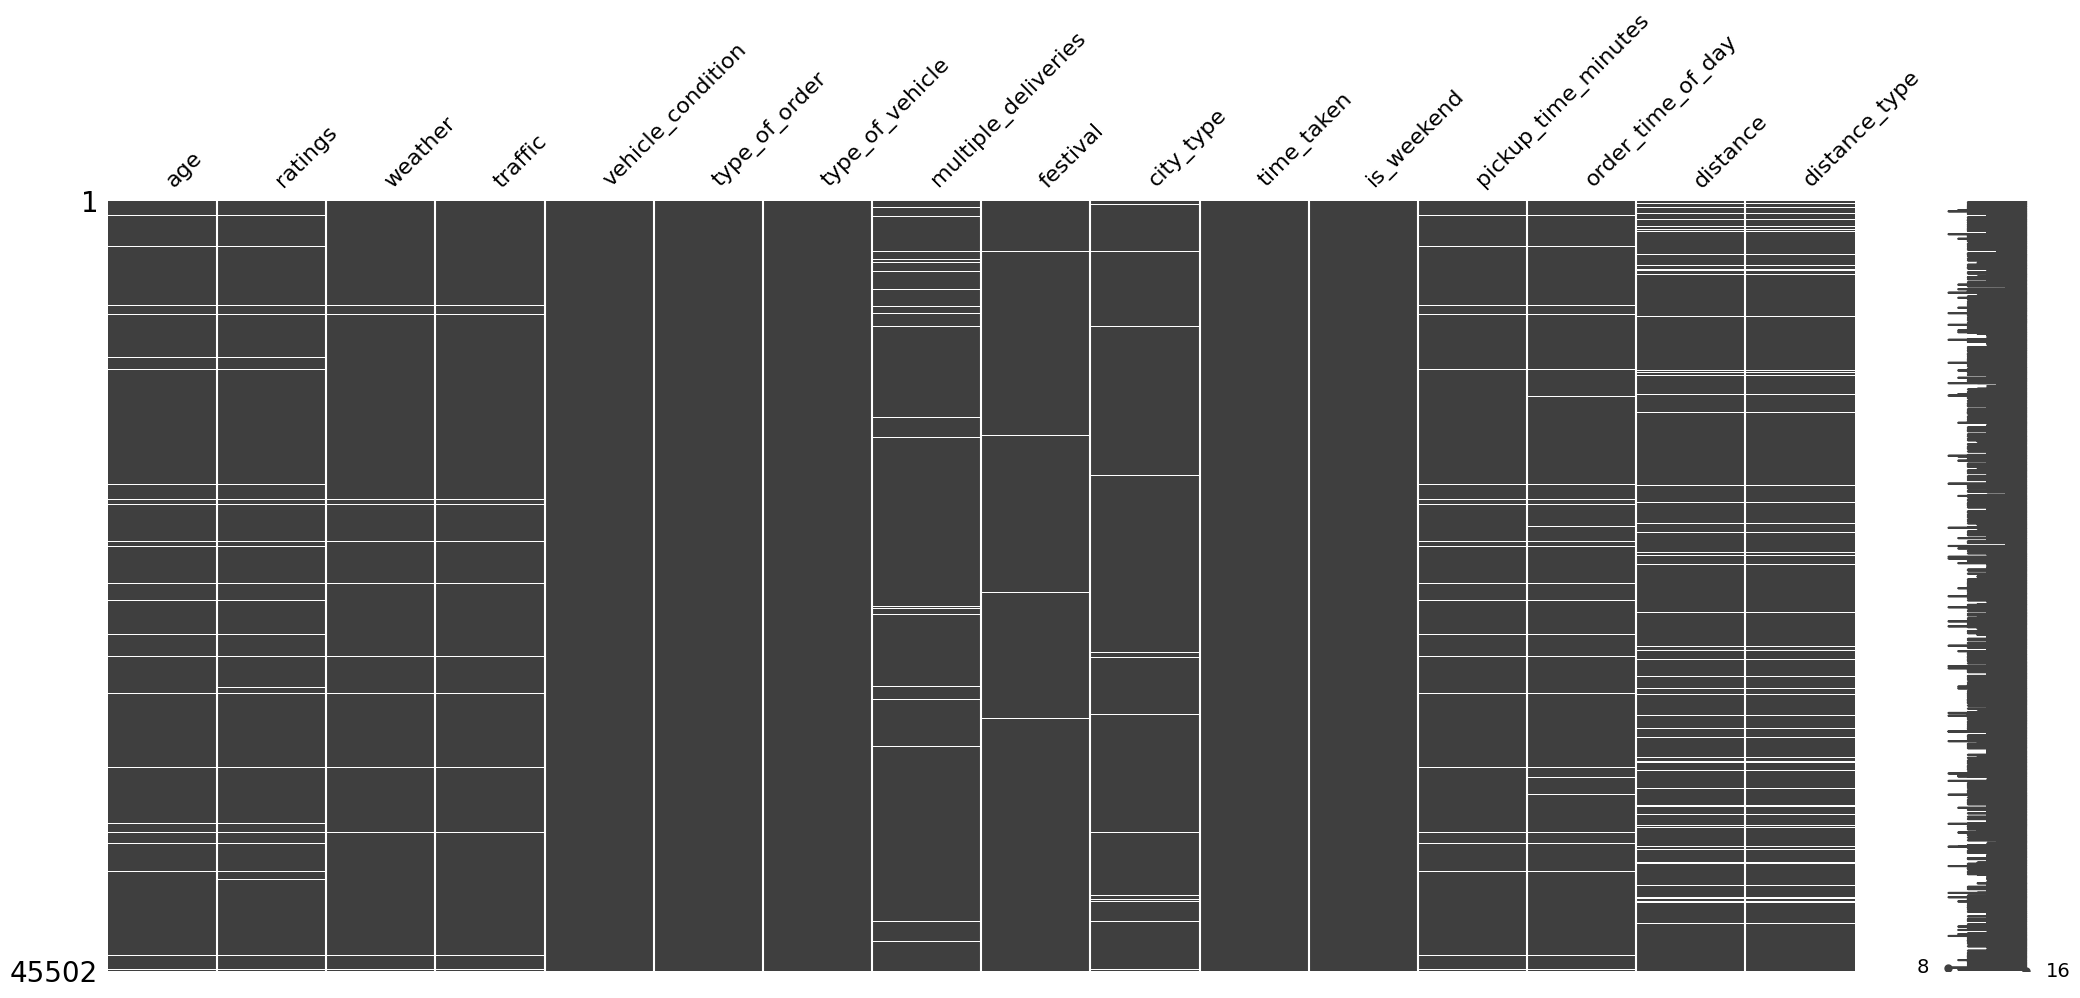

In [14]:
import missingno as msno

msno.matrix(swiggy_cleaned)

In [15]:
# columns that have missing values

missing_cols = (
                    swiggy_cleaned
                    .isna()
                    .any(axis=0)
                    .loc[lambda x: x]
                    .index
                )

missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

# Drop Missing values

In [16]:
temp_df = swiggy_cleaned.copy().dropna()

In [17]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45587,35.0,4.2,windy,jam,2,drinks,motorcycle,1.0,no,metropolitian,0,10.0,night,16.600272,very_long
45588,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,0,10.0,morning,1.489846,short
45590,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,0,15.0,night,4.657195,short
45591,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,0,5.0,afternoon,6.232393,medium


In [18]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [19]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (30156, 15)
The shape of test data is (7539, 15)


In [20]:
# missing values in train data

X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [21]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [22]:
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

In [23]:
# percentage of rows in data having missing values

(
    X_train
    .isna()
    .any(axis=1)
    .mean()
    .round(2) * 100
)


np.float64(0.0)

# Pre-Processing Pipeline

In [24]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [25]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [26]:
# unique categories the ordinal columns

for col in ordinal_cat_cols:
    print(col,X_train[col].unique())

traffic ['jam' 'medium' 'high' 'low']
distance_type ['medium', 'short', 'long', 'very_long']
Categories (4, object): ['short' < 'medium' < 'long' < 'very_long']


In [27]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",
                                     sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order],
                                      encoded_missing_value=-999,
                                      handle_unknown="use_encoded_value",
                                      unknown_value=-1), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)


preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'is_weekend',
                                  'order_time_of_day']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']],
                                                encoded_missing_value=-999,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

In [28]:
# build the pipeline

processing_pipeline = Pipeline(steps=[
                                ("preprocess",preprocessor)
                            ])

processing_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('scale', MinMaxScaler(),
                                                  ['age', 'ratings',
                                                   'pickup_time_minutes',
                                                   'distance']),
                                                 ('nominal_encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['weather', 'type_of_order',
                                                   'type_of_vehicle',
                                                   'festival', 'city_type',
                                                   'is_weekend',
                                                   'order_time_of_day']),
                                                 ('ordinal_encode',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high',
                                                                              'jam'],
                                                                             ['short',
                                                                              'medium',
                                                                              'long',
                                                                              'very_long']],
                                                                 encoded_missing_value=-999,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['traffic',
                                                   'distance_type'])],
                                   verbose_feature_names_out=False))])

In [29]:
# do data preprocessing

X_train_trans = processing_pipeline.fit_transform(X_train)

X_test_trans = processing_pipeline.transform(X_test)

In [30]:
X_train_trans

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,city_type_semi-urban,city_type_urban,is_weekend_1,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,traffic,distance_type,vehicle_condition,multiple_deliveries
8720,0.473684,0.56,1.0,0.404165,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0,2.0
25245,1.000000,0.76,0.0,0.154044,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1.0
34118,0.473684,0.80,0.5,0.002461,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1,0.0
26036,1.000000,0.92,1.0,0.460411,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0,1.0
37194,0.526316,0.76,0.5,0.243676,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20275,0.578947,0.92,0.5,0.451895,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,0,0.0
7601,0.052632,1.00,1.0,0.612270,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1,1.0
13632,0.526316,0.92,0.0,0.322877,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,0.0
1045,0.947368,0.96,0.5,0.004486,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1.0


In [31]:
from lightgbm import LGBMRegressor
import optuna

c:\Users\Admin\anaconda3\envs\swiggy_prediction_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor

In [33]:
def objective(trial):
    with mlflow.start_run(nested=True):
        params = {
            "n_estimators": trial.suggest_int("n_estimators",10,200),
            "max_depth": trial.suggest_int("max_depth",1,40),
            "learning_rate": trial.suggest_float("learning_rate",0.1,0.8),
            "subsample": trial.suggest_float("subsample",0.5,1),
            "min_child_weight": trial.suggest_int("min_child_weight",5,20),
            "min_split_gain": trial.suggest_float("min_split_gain",0,10),
            "reg_lambda": trial.suggest_float("reg_lambda",0,100),
            "random_state": 42,
            "n_jobs": -1,
        }

        # log model parameters
        mlflow.log_params(params)

        xgb_reg = LGBMRegressor(**params)
        model = TransformedTargetRegressor(regressor=xgb_reg,transformer=pt)

        # train the model
        model.fit(X_train_trans,y_train)

        # get the predictions
        y_pred_train = model.predict(X_train_trans)
        y_pred_test = model.predict(X_test_trans)


        # perform cross validation
        cv_score = cross_val_score(model,
                                X_train_trans,
                                y_train,
                                cv=5,
                                scoring="neg_mean_absolute_error",
                                n_jobs=-1)

        # mean score
        mean_score = -(cv_score.mean())
        # log avg cross val error
        mlflow.log_metric("cross_val_error",mean_score)

        return mean_score

In [34]:
# create optuna study
study = optuna.create_study(direction="minimize")

with mlflow.start_run(run_name="best_model"):
    # optimize the objective function
    study.optimize(objective, n_trials=50, n_jobs=-1, show_progress_bar=True)

    # log the best parameters
    mlflow.log_params(study.best_params)

    # log the best score
    mlflow.log_metric("best_score", study.best_value)

    # train the model on best parameters
    best_lgbm = LGBMRegressor(**study.best_params)
    best_lgbm.fit(X_train_trans, y_train_pt.values.ravel())

    # get the predictions
    y_pred_train = best_lgbm.predict(X_train_trans)
    y_pred_test = best_lgbm.predict(X_test_trans)

    # get the actual predictions values
    y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1, 1))
    y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1, 1))

    # perform cross validation
    model = TransformedTargetRegressor(regressor=best_lgbm,
                                       transformer=pt)

    scores = cross_val_score(model,
                             X_train_trans,
                             y_train,
                             scoring="neg_mean_absolute_error",
                             cv=5, n_jobs=-1)

    # log metrics
    mlflow.log_metric("training_error", mean_absolute_error(y_train, y_pred_train_org))
    mlflow.log_metric("test_error", mean_absolute_error(y_test, y_pred_test_org))
    mlflow.log_metric("training_r2", r2_score(y_train, y_pred_train_org))
    mlflow.log_metric("test_r2", r2_score(y_test, y_pred_test_org))
    mlflow.log_metric("cross_val", -scores.mean())

    # ---- FIXED PART ----
    # save model locally
    model_path = "best_lgbm.pkl"
    joblib.dump(best_lgbm, model_path)

    # log as artifact (works with DagsHub MLflow)
    mlflow.log_artifact(model_path, artifact_path="model")

[I 2025-10-01 10:21:53,943] A new study created in memory with name: no-name-0bd40837-e04c-4f85-8795-88ba4a8228d9
  0%|          | 0/50 [00:00<?, ?it/s]

🏃 View run calm-finch-342 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/6deaad953776414db62e265a77b4a23e
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run dashing-skink-615 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/5af1bb4239fa4d9e83d487022dbbfdcc
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run chill-cat-446 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/072826fe6e3a4748983c8d950627bba6
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 2. Best value: 3.38543:   2%|▏         | 1/50 [00:47<39:08, 47.93s/it]

[I 2025-10-01 10:22:42,792] Trial 2 finished with value: 3.3854297599633556 and parameters: {'n_estimators': 16, 'max_depth': 7, 'learning_rate': 0.4689159310792107, 'subsample': 0.525427805523271, 'min_child_weight': 9, 'min_split_gain': 0.9571009567509503, 'reg_lambda': 34.42611532907901}. Best is trial 2 with value: 3.3854297599633556.
🏃 View run polite-shoat-865 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/26823f4bd53b4babae433aa0c9fe514f
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 2. Best value: 3.38543:   4%|▍         | 2/50 [00:51<17:19, 21.66s/it]

[I 2025-10-01 10:22:46,064] Trial 6 finished with value: 3.6694782445928262 and parameters: {'n_estimators': 100, 'max_depth': 34, 'learning_rate': 0.7537654258077996, 'subsample': 0.9313946096852601, 'min_child_weight': 9, 'min_split_gain': 5.3294281929708465, 'reg_lambda': 48.813011620360214}. Best is trial 2 with value: 3.3854297599633556.


Best trial: 2. Best value: 3.38543:   6%|▌         | 3/50 [00:54<10:19, 13.17s/it]

[I 2025-10-01 10:22:49,141] Trial 10 finished with value: 3.744700674596732 and parameters: {'n_estimators': 41, 'max_depth': 12, 'learning_rate': 0.5510028762735452, 'subsample': 0.6345733259052244, 'min_child_weight': 11, 'min_split_gain': 5.7201868437265535, 'reg_lambda': 12.062413703571796}. Best is trial 2 with value: 3.3854297599633556.
🏃 View run efficient-hawk-446 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/6404915de8ce4d30acf8adfd6934697a
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run skillful-duck-76 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/87b11505efc04e62a0c1ee4f1061ef3d
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run smiling-rat-63 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction

Best trial: 2. Best value: 3.38543:   8%|▊         | 4/50 [00:58<07:32,  9.83s/it]

[I 2025-10-01 10:22:53,843] Trial 7 finished with value: 3.5776070004985128 and parameters: {'n_estimators': 84, 'max_depth': 26, 'learning_rate': 0.5494845944645539, 'subsample': 0.9101867581861371, 'min_child_weight': 9, 'min_split_gain': 2.5996625044819655, 'reg_lambda': 58.6325097764783}. Best is trial 2 with value: 3.3854297599633556.
🏃 View run hilarious-ox-468 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/83dbead6e3b540c19245ab2b86186efa
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run kindly-trout-274 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/9b0fe7a4b0e146edae7686a557ccf7f0
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 2. Best value: 3.38543:  10%|█         | 5/50 [01:05<06:25,  8.58s/it]

[I 2025-10-01 10:23:00,192] Trial 9 finished with value: 3.5954864079410234 and parameters: {'n_estimators': 148, 'max_depth': 9, 'learning_rate': 0.6901072513774872, 'subsample': 0.8789469990958876, 'min_child_weight': 18, 'min_split_gain': 2.9377294460042123, 'reg_lambda': 16.992497377599957}. Best is trial 2 with value: 3.3854297599633556.


Best trial: 2. Best value: 3.38543:  12%|█▏        | 6/50 [01:06<04:19,  5.90s/it]

[I 2025-10-01 10:23:00,915] Trial 0 finished with value: 3.5175209140257935 and parameters: {'n_estimators': 122, 'max_depth': 33, 'learning_rate': 0.31030896072368336, 'subsample': 0.773406938175941, 'min_child_weight': 5, 'min_split_gain': 3.0962046421726788, 'reg_lambda': 0.4406202638361223}. Best is trial 2 with value: 3.3854297599633556.


Best trial: 2. Best value: 3.38543:  14%|█▍        | 7/50 [01:06<03:03,  4.27s/it]

[I 2025-10-01 10:23:01,836] Trial 1 finished with value: 3.717246175107013 and parameters: {'n_estimators': 192, 'max_depth': 30, 'learning_rate': 0.4982537069229218, 'subsample': 0.7551121415599142, 'min_child_weight': 17, 'min_split_gain': 7.225553922864767, 'reg_lambda': 49.39472407263753}. Best is trial 2 with value: 3.3854297599633556.


Best trial: 2. Best value: 3.38543:  16%|█▌        | 8/50 [01:09<02:41,  3.85s/it]

[I 2025-10-01 10:23:04,775] Trial 8 finished with value: 3.822104936370578 and parameters: {'n_estimators': 148, 'max_depth': 37, 'learning_rate': 0.798223952229036, 'subsample': 0.728033787480177, 'min_child_weight': 20, 'min_split_gain': 8.534554526785286, 'reg_lambda': 85.27238447289812}. Best is trial 2 with value: 3.3854297599633556.
🏃 View run capricious-swan-907 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/0046081ff32a421384345ae8f35a0194
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 2. Best value: 3.38543:  18%|█▊        | 9/50 [01:13<02:28,  3.62s/it]

[I 2025-10-01 10:23:07,880] Trial 3 finished with value: 3.6743753043120697 and parameters: {'n_estimators': 141, 'max_depth': 5, 'learning_rate': 0.5432905258762583, 'subsample': 0.6891327633445514, 'min_child_weight': 15, 'min_split_gain': 2.6279345394605427, 'reg_lambda': 95.52348844763631}. Best is trial 2 with value: 3.3854297599633556.


Best trial: 2. Best value: 3.38543:  20%|██        | 10/50 [01:20<03:18,  4.96s/it]

[I 2025-10-01 10:23:15,867] Trial 11 finished with value: 3.5598901262549605 and parameters: {'n_estimators': 181, 'max_depth': 21, 'learning_rate': 0.28405375137953476, 'subsample': 0.6740620779355142, 'min_child_weight': 7, 'min_split_gain': 2.858496957282022, 'reg_lambda': 76.44218451838957}. Best is trial 2 with value: 3.3854297599633556.
🏃 View run awesome-eel-6 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/8923b367eec34100aa661781f0d57e6f
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run puzzled-zebra-131 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/f11bd103560746dd9ccd7763ccbd19ce
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run whimsical-cub-882 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1

Best trial: 2. Best value: 3.38543:  22%|██▏       | 11/50 [02:02<10:27, 16.08s/it]

[I 2025-10-01 10:23:57,142] Trial 4 finished with value: 3.6377459438941755 and parameters: {'n_estimators': 189, 'max_depth': 28, 'learning_rate': 0.3592441410380979, 'subsample': 0.9263413537629761, 'min_child_weight': 7, 'min_split_gain': 4.438550232860312, 'reg_lambda': 65.43826710387346}. Best is trial 2 with value: 3.3854297599633556.


Best trial: 2. Best value: 3.38543:  24%|██▍       | 12/50 [02:03<07:14, 11.43s/it]

[I 2025-10-01 10:23:57,944] Trial 12 finished with value: 3.627806903342885 and parameters: {'n_estimators': 184, 'max_depth': 11, 'learning_rate': 0.6369117051640121, 'subsample': 0.8465539708935816, 'min_child_weight': 6, 'min_split_gain': 3.1762646198126108, 'reg_lambda': 40.28703247780171}. Best is trial 2 with value: 3.3854297599633556.
🏃 View run respected-wren-604 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/4f5cfe9b139a4f1bb44b1f6b1357c6e0
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 14. Best value: 3.24603:  26%|██▌       | 13/50 [02:05<05:26,  8.84s/it]

[I 2025-10-01 10:24:00,808] Trial 14 finished with value: 3.246034436967188 and parameters: {'n_estimators': 36, 'max_depth': 30, 'learning_rate': 0.1377907814941166, 'subsample': 0.9524370367853592, 'min_child_weight': 14, 'min_split_gain': 0.07617237392851472, 'reg_lambda': 49.38617907557186}. Best is trial 14 with value: 3.246034436967188.


Best trial: 14. Best value: 3.24603:  28%|██▊       | 14/50 [02:06<03:53,  6.48s/it]

[I 2025-10-01 10:24:01,841] Trial 5 finished with value: 3.7655755687763905 and parameters: {'n_estimators': 81, 'max_depth': 7, 'learning_rate': 0.6853193260189612, 'subsample': 0.807348603392618, 'min_child_weight': 10, 'min_split_gain': 8.35243302939067, 'reg_lambda': 49.17852150332623}. Best is trial 14 with value: 3.246034436967188.


Best trial: 14. Best value: 3.24603:  30%|███       | 15/50 [02:07<02:49,  4.83s/it]

[I 2025-10-01 10:24:02,862] Trial 13 finished with value: 3.763339857008879 and parameters: {'n_estimators': 193, 'max_depth': 11, 'learning_rate': 0.7378885831181523, 'subsample': 0.6323839421891667, 'min_child_weight': 15, 'min_split_gain': 6.759527159945118, 'reg_lambda': 26.40637292184824}. Best is trial 14 with value: 3.246034436967188.
🏃 View run dazzling-lynx-519 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/6bc090c6c6a8485f86c4ddb58c6f0525
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run intrigued-cod-955 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/bc13a7c7fa0543049a3c02d135a93de2
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run capricious-crow-345 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-predic

Best trial: 14. Best value: 3.24603:  32%|███▏      | 16/50 [02:14<03:06,  5.48s/it]

[I 2025-10-01 10:24:09,825] Trial 16 finished with value: 3.758181810738921 and parameters: {'n_estimators': 142, 'max_depth': 2, 'learning_rate': 0.7555128159828676, 'subsample': 0.9365771861427488, 'min_child_weight': 20, 'min_split_gain': 0.9844510276412521, 'reg_lambda': 1.5870582369328923}. Best is trial 14 with value: 3.246034436967188.


Best trial: 14. Best value: 3.24603:  34%|███▍      | 17/50 [02:19<02:46,  5.05s/it]

[I 2025-10-01 10:24:13,890] Trial 18 finished with value: 3.246756558074747 and parameters: {'n_estimators': 142, 'max_depth': 24, 'learning_rate': 0.4235547867769043, 'subsample': 0.7481459310957954, 'min_child_weight': 12, 'min_split_gain': 0.09966039416569816, 'reg_lambda': 95.05401851155877}. Best is trial 14 with value: 3.246034436967188.
🏃 View run caring-goose-34 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/b4fe1077e7cd40e8af612e0630baffec
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 14. Best value: 3.24603:  36%|███▌      | 18/50 [02:21<02:12,  4.13s/it]

[I 2025-10-01 10:24:15,873] Trial 19 finished with value: 3.753540888983133 and parameters: {'n_estimators': 143, 'max_depth': 39, 'learning_rate': 0.4167592704488824, 'subsample': 0.9571756240620483, 'min_child_weight': 5, 'min_split_gain': 8.358809982899778, 'reg_lambda': 13.380158817385034}. Best is trial 14 with value: 3.246034436967188.
🏃 View run amusing-frog-670 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/de1463e23ac84d409056e2ea28ce39ef
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 14. Best value: 3.24603:  38%|███▊      | 19/50 [02:24<01:59,  3.84s/it]

[I 2025-10-01 10:24:19,045] Trial 20 finished with value: 5.225232285692094 and parameters: {'n_estimators': 26, 'max_depth': 1, 'learning_rate': 0.14832728427534542, 'subsample': 0.5022313207416642, 'min_child_weight': 13, 'min_split_gain': 0.019277806665443653, 'reg_lambda': 32.6517318634033}. Best is trial 14 with value: 3.246034436967188.


Best trial: 14. Best value: 3.24603:  40%|████      | 20/50 [02:29<02:12,  4.42s/it]

[I 2025-10-01 10:24:24,814] Trial 21 finished with value: 5.149255969224042 and parameters: {'n_estimators': 26, 'max_depth': 1, 'learning_rate': 0.1599809361995414, 'subsample': 0.5239427019169367, 'min_child_weight': 13, 'min_split_gain': 0.09343014014990636, 'reg_lambda': 30.454539100605636}. Best is trial 14 with value: 3.246034436967188.


Best trial: 14. Best value: 3.24603:  42%|████▏     | 21/50 [02:31<01:46,  3.68s/it]

[I 2025-10-01 10:24:26,790] Trial 17 finished with value: 3.28279077938909 and parameters: {'n_estimators': 18, 'max_depth': 11, 'learning_rate': 0.5874749479950978, 'subsample': 0.5855560528176458, 'min_child_weight': 20, 'min_split_gain': 0.07631366687280705, 'reg_lambda': 49.52905384558619}. Best is trial 14 with value: 3.246034436967188.
🏃 View run treasured-hare-274 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/e1c1cbfbc0e14d6291fb5772e9e5547c
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run calm-mule-781 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/6dffb6daa52b489894c760e31c3394b0
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 14. Best value: 3.24603:  44%|████▍     | 22/50 [11:30<1:16:37, 164.20s/it]

[I 2025-10-01 10:33:25,307] Trial 24 finished with value: 3.6469595585277474 and parameters: {'n_estimators': 20, 'max_depth': 20, 'learning_rate': 0.10516540344440542, 'subsample': 0.5148611841993574, 'min_child_weight': 13, 'min_split_gain': 0.07608282438670722, 'reg_lambda': 34.08143606716417}. Best is trial 14 with value: 3.246034436967188.
🏃 View run indecisive-robin-124 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/ec1ddd7040ea466cbeaee5d871626321
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 14. Best value: 3.24603:  46%|████▌     | 23/50 [11:32<52:02, 115.64s/it]  

[I 2025-10-01 10:33:27,685] Trial 25 finished with value: 3.722829198762181 and parameters: {'n_estimators': 18, 'max_depth': 18, 'learning_rate': 0.10933264130654255, 'subsample': 0.5026221739077354, 'min_child_weight': 13, 'min_split_gain': 0.14440769128172615, 'reg_lambda': 32.47812323329157}. Best is trial 14 with value: 3.246034436967188.
🏃 View run learned-calf-851 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/956fe05d518847e1a4832070b3e248b2
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 27. Best value: 3.21804:  48%|████▊     | 24/50 [11:37<35:40, 82.33s/it] 

[I 2025-10-01 10:33:32,307] Trial 27 finished with value: 3.218042845985626 and parameters: {'n_estimators': 57, 'max_depth': 18, 'learning_rate': 0.11508843979525717, 'subsample': 0.8219692257816482, 'min_child_weight': 12, 'min_split_gain': 0.1266801534144861, 'reg_lambda': 70.7734573994436}. Best is trial 27 with value: 3.218042845985626.


c:\Users\Admin\anaconda3\envs\swiggy_prediction_env\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


🏃 View run skillful-squid-767 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/4b38cb00c21e42b7a73cee6fdc6ff0b9
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run skittish-skink-110 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/18b12473b9dc4d9db149f79c2f61f63f
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run clumsy-stoat-312 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/9bab99145a35409ca098d7ead6067a4d
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 27. Best value: 3.21804:  50%|█████     | 25/50 [11:50<25:38, 61.52s/it]

[I 2025-10-01 10:33:45,308] Trial 26 finished with value: 4.0545361927907155 and parameters: {'n_estimators': 12, 'max_depth': 17, 'learning_rate': 0.1269493435098635, 'subsample': 0.5018964328092856, 'min_child_weight': 13, 'min_split_gain': 0.10585497576170677, 'reg_lambda': 35.93061795006863}. Best is trial 27 with value: 3.218042845985626.


Best trial: 27. Best value: 3.21804:  52%|█████▏    | 26/50 [11:53<17:35, 43.99s/it]

[I 2025-10-01 10:33:48,387] Trial 30 finished with value: 3.45576093998573 and parameters: {'n_estimators': 54, 'max_depth': 17, 'learning_rate': 0.19967535317869753, 'subsample': 0.6208741135155407, 'min_child_weight': 15, 'min_split_gain': 1.2995461909809178, 'reg_lambda': 68.55542159655411}. Best is trial 27 with value: 3.218042845985626.


Best trial: 27. Best value: 3.21804:  54%|█████▍    | 27/50 [11:54<11:55, 31.13s/it]

[I 2025-10-01 10:33:49,492] Trial 29 finished with value: 3.4509822394319563 and parameters: {'n_estimators': 55, 'max_depth': 18, 'learning_rate': 0.2427779518148176, 'subsample': 0.9951630178352382, 'min_child_weight': 15, 'min_split_gain': 1.4191122727882801, 'reg_lambda': 70.62041474566946}. Best is trial 27 with value: 3.218042845985626.
🏃 View run invincible-grub-9 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/45601d2ff55341249e2861cace960911
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 27. Best value: 3.21804:  56%|█████▌    | 28/50 [11:59<08:31, 23.24s/it]

[I 2025-10-01 10:33:54,327] Trial 23 finished with value: 6.438552402180089 and parameters: {'n_estimators': 10, 'max_depth': 1, 'learning_rate': 0.11016769607488738, 'subsample': 0.5260939133239665, 'min_child_weight': 13, 'min_split_gain': 0.11597295975410121, 'reg_lambda': 29.661674064518152}. Best is trial 27 with value: 3.218042845985626.


Best trial: 27. Best value: 3.21804:  58%|█████▊    | 29/50 [12:04<06:13, 17.80s/it]

[I 2025-10-01 10:33:59,447] Trial 22 finished with value: 3.7257188241428865 and parameters: {'n_estimators': 12, 'max_depth': 18, 'learning_rate': 0.16086987313768158, 'subsample': 0.5018047298323253, 'min_child_weight': 13, 'min_split_gain': 0.1370826297760516, 'reg_lambda': 30.42793965010624}. Best is trial 27 with value: 3.218042845985626.
🏃 View run beautiful-wren-233 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/6e97a99130614e45bcf4b59bc95cbf24
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run judicious-sponge-263 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/3f6ab29caa1d4fc9b01b2875d5aec430
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 27. Best value: 3.21804:  60%|██████    | 30/50 [12:14<05:08, 15.44s/it]

[I 2025-10-01 10:34:09,375] Trial 28 finished with value: 3.4652300400292155 and parameters: {'n_estimators': 58, 'max_depth': 17, 'learning_rate': 0.23706859320159784, 'subsample': 0.6112723508979656, 'min_child_weight': 15, 'min_split_gain': 1.2607154446748936, 'reg_lambda': 65.29842244531747}. Best is trial 27 with value: 3.218042845985626.


Best trial: 27. Best value: 3.21804:  62%|██████▏   | 31/50 [12:18<03:47, 11.99s/it]

[I 2025-10-01 10:34:13,315] Trial 31 finished with value: 3.5069022127455844 and parameters: {'n_estimators': 69, 'max_depth': 17, 'learning_rate': 0.20972980500848273, 'subsample': 0.5866105753551986, 'min_child_weight': 15, 'min_split_gain': 1.454131459056938, 'reg_lambda': 65.07033242773615}. Best is trial 27 with value: 3.218042845985626.
🏃 View run grandiose-cat-429 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/c99bb857327a4cf1a6c7c6a1abfab4e9
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 27. Best value: 3.21804:  64%|██████▍   | 32/50 [12:37<04:13, 14.09s/it]

[I 2025-10-01 10:34:32,314] Trial 32 finished with value: 3.4714530354180653 and parameters: {'n_estimators': 58, 'max_depth': 18, 'learning_rate': 0.22170353403774568, 'subsample': 0.9988605825047381, 'min_child_weight': 15, 'min_split_gain': 1.4303125387863431, 'reg_lambda': 64.71831375904003}. Best is trial 27 with value: 3.218042845985626.
🏃 View run adaptable-rook-801 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/42e23f20b58c49f781716462e3e08dec
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run enthused-pig-218 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/a49f1c277f9e472eaa5a4c04933ebfa1
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run hilarious-mink-635 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-predi

Best trial: 27. Best value: 3.21804:  66%|██████▌   | 33/50 [12:54<04:14, 14.99s/it]

[I 2025-10-01 10:34:49,414] Trial 33 finished with value: 3.497474740992291 and parameters: {'n_estimators': 46, 'max_depth': 24, 'learning_rate': 0.22489378681331154, 'subsample': 0.5811041696982859, 'min_child_weight': 15, 'min_split_gain': 1.5804472479388758, 'reg_lambda': 65.34563745349827}. Best is trial 27 with value: 3.218042845985626.
🏃 View run useful-lark-899 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/4064005a613e4d108217c8b3c1dc90ef
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run amusing-fawn-233 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/e9d3bbe35d6e413c8c32babf3c7ae52f
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run amusing-mink-17 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.

Best trial: 27. Best value: 3.21804:  68%|██████▊   | 34/50 [13:03<03:31, 13.20s/it]

[I 2025-10-01 10:34:58,413] Trial 37 finished with value: 3.526879859341669 and parameters: {'n_estimators': 71, 'max_depth': 24, 'learning_rate': 0.2036400293995943, 'subsample': 0.8275009120850559, 'min_child_weight': 11, 'min_split_gain': 1.9416449276622365, 'reg_lambda': 95.0430186017445}. Best is trial 27 with value: 3.218042845985626.


Best trial: 27. Best value: 3.21804:  70%|███████   | 35/50 [13:05<02:26,  9.80s/it]

[I 2025-10-01 10:35:00,292] Trial 38 finished with value: 3.7769030853290273 and parameters: {'n_estimators': 69, 'max_depth': 24, 'learning_rate': 0.19504668028118805, 'subsample': 0.8187823643815971, 'min_child_weight': 11, 'min_split_gain': 9.916764930065689, 'reg_lambda': 99.84411041752529}. Best is trial 27 with value: 3.218042845985626.


Best trial: 27. Best value: 3.21804:  72%|███████▏  | 36/50 [13:06<01:41,  7.22s/it]

[I 2025-10-01 10:35:01,493] Trial 35 finished with value: 3.502278332745429 and parameters: {'n_estimators': 52, 'max_depth': 23, 'learning_rate': 0.21573738782967605, 'subsample': 0.9966363379001189, 'min_child_weight': 15, 'min_split_gain': 1.5223881650781044, 'reg_lambda': 71.71401879109929}. Best is trial 27 with value: 3.218042845985626.


Best trial: 27. Best value: 3.21804:  74%|███████▍  | 37/50 [13:07<01:08,  5.30s/it]

[I 2025-10-01 10:35:02,289] Trial 15 finished with value: 3.7597274789835198 and parameters: {'n_estimators': 24, 'max_depth': 11, 'learning_rate': 0.26369562514393613, 'subsample': 0.9714126692997302, 'min_child_weight': 11, 'min_split_gain': 9.473271785318536, 'reg_lambda': 54.532152171205524}. Best is trial 27 with value: 3.218042845985626.


Best trial: 27. Best value: 3.21804:  76%|███████▌  | 38/50 [13:10<00:55,  4.62s/it]

[I 2025-10-01 10:35:05,340] Trial 39 finished with value: 3.505486818009549 and parameters: {'n_estimators': 125, 'max_depth': 24, 'learning_rate': 0.3565113850140944, 'subsample': 0.8076597297864873, 'min_child_weight': 11, 'min_split_gain': 1.860691179825058, 'reg_lambda': 99.96458780036039}. Best is trial 27 with value: 3.218042845985626.


Best trial: 27. Best value: 3.21804:  78%|███████▊  | 39/50 [13:11<00:38,  3.53s/it]

[I 2025-10-01 10:35:06,325] Trial 34 finished with value: 3.4815893804900933 and parameters: {'n_estimators': 51, 'max_depth': 23, 'learning_rate': 0.20312798352760647, 'subsample': 0.9874761749516169, 'min_child_weight': 15, 'min_split_gain': 1.342939260229924, 'reg_lambda': 97.00486914352506}. Best is trial 27 with value: 3.218042845985626.
🏃 View run nebulous-ram-974 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/c20b0d6a851f4558a692196146e1f4e5
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run gifted-trout-248 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/e7ef021758a046c6bde579946019de5f
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run enthused-bass-829 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-predictio

Best trial: 27. Best value: 3.21804:  80%|████████  | 40/50 [13:27<01:12,  7.29s/it]

[I 2025-10-01 10:35:22,385] Trial 40 finished with value: 3.4972926162613867 and parameters: {'n_estimators': 125, 'max_depth': 24, 'learning_rate': 0.34174423288925904, 'subsample': 0.8017036002016193, 'min_child_weight': 11, 'min_split_gain': 1.8344005322538124, 'reg_lambda': 93.64068346608407}. Best is trial 27 with value: 3.218042845985626.


Best trial: 27. Best value: 3.21804:  82%|████████▏ | 41/50 [13:28<00:48,  5.41s/it]

[I 2025-10-01 10:35:23,406] Trial 41 finished with value: 3.5229352397252236 and parameters: {'n_estimators': 38, 'max_depth': 25, 'learning_rate': 0.38260582869900867, 'subsample': 0.8114434355885455, 'min_child_weight': 11, 'min_split_gain': 2.112605467098474, 'reg_lambda': 99.8761108974821}. Best is trial 27 with value: 3.218042845985626.


Best trial: 27. Best value: 3.21804:  84%|████████▍ | 42/50 [13:34<00:45,  5.69s/it]

[I 2025-10-01 10:35:29,755] Trial 42 finished with value: 3.5508481992179783 and parameters: {'n_estimators': 38, 'max_depth': 24, 'learning_rate': 0.3455962669846323, 'subsample': 0.8166757701381229, 'min_child_weight': 11, 'min_split_gain': 2.046942654730564, 'reg_lambda': 99.19777123293291}. Best is trial 27 with value: 3.218042845985626.


Best trial: 27. Best value: 3.21804:  86%|████████▌ | 43/50 [13:37<00:33,  4.74s/it]

[I 2025-10-01 10:35:32,288] Trial 36 finished with value: 3.510778637271012 and parameters: {'n_estimators': 72, 'max_depth': 24, 'learning_rate': 0.20244591938163217, 'subsample': 0.8325720257608847, 'min_child_weight': 11, 'min_split_gain': 1.7732345703723156, 'reg_lambda': 98.86038908130979}. Best is trial 27 with value: 3.218042845985626.
🏃 View run selective-slug-207 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/07e410f5ab974068af2eb862d73f9bdf
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 27. Best value: 3.21804:  88%|████████▊ | 44/50 [13:45<00:34,  5.82s/it]

[I 2025-10-01 10:35:40,612] Trial 43 finished with value: 3.5212516961560327 and parameters: {'n_estimators': 40, 'max_depth': 26, 'learning_rate': 0.36373028913853606, 'subsample': 0.7864055540236015, 'min_child_weight': 11, 'min_split_gain': 2.134652671323619, 'reg_lambda': 99.16336821156321}. Best is trial 27 with value: 3.218042845985626.
🏃 View run overjoyed-boar-186 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/d4084d3fa3fb46f79a12d5012a4a7ef9
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run stately-bear-950 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/431d0734ea404d51824cead940f3aff1
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 27. Best value: 3.21804:  90%|█████████ | 45/50 [13:56<00:36,  7.39s/it]

[I 2025-10-01 10:35:51,667] Trial 44 finished with value: 3.442995364468632 and parameters: {'n_estimators': 121, 'max_depth': 32, 'learning_rate': 0.3575158996652282, 'subsample': 0.7884471836036463, 'min_child_weight': 17, 'min_split_gain': 0.7774009617152531, 'reg_lambda': 55.327380173988395}. Best is trial 27 with value: 3.218042845985626.
🏃 View run industrious-vole-584 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/9ae4d508cad7418589c697ac95024311
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run nervous-deer-649 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/03ff5306923144fabb1c9411854ed844
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 27. Best value: 3.21804:  92%|█████████▏| 46/50 [14:00<00:25,  6.28s/it]

[I 2025-10-01 10:35:55,357] Trial 45 finished with value: 3.5492887815100196 and parameters: {'n_estimators': 37, 'max_depth': 31, 'learning_rate': 0.5933604368206, 'subsample': 0.7656486190040341, 'min_child_weight': 17, 'min_split_gain': 2.0774610973838374, 'reg_lambda': 81.7496874172512}. Best is trial 27 with value: 3.218042845985626.
🏃 View run dashing-sheep-412 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/28e8fa9ed1ca466ebc287a97862bb80f
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19
🏃 View run nervous-squirrel-210 at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/54d742de47d946da9e04d210e119d787
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19


Best trial: 27. Best value: 3.21804:  94%|█████████▍| 47/50 [14:03<00:15,  5.29s/it]

[I 2025-10-01 10:35:58,319] Trial 46 finished with value: 3.5217817894162438 and parameters: {'n_estimators': 36, 'max_depth': 31, 'learning_rate': 0.491130104622687, 'subsample': 0.7747511491774696, 'min_child_weight': 17, 'min_split_gain': 2.259686777086089, 'reg_lambda': 83.38465819110398}. Best is trial 27 with value: 3.218042845985626.


Best trial: 27. Best value: 3.21804:  96%|█████████▌| 48/50 [14:04<00:08,  4.04s/it]

[I 2025-10-01 10:35:59,454] Trial 47 finished with value: 3.5978434168481486 and parameters: {'n_estimators': 33, 'max_depth': 31, 'learning_rate': 0.6018709935037136, 'subsample': 0.7573710048375688, 'min_child_weight': 18, 'min_split_gain': 3.9475316680991575, 'reg_lambda': 44.75311535172385}. Best is trial 27 with value: 3.218042845985626.


Best trial: 27. Best value: 3.21804:  98%|█████████▊| 49/50 [14:05<00:03,  3.12s/it]

[I 2025-10-01 10:36:00,420] Trial 48 finished with value: 3.4196600377288062 and parameters: {'n_estimators': 37, 'max_depth': 29, 'learning_rate': 0.6061044379304994, 'subsample': 0.763235860954615, 'min_child_weight': 19, 'min_split_gain': 0.7087750217381332, 'reg_lambda': 43.84341899831}. Best is trial 27 with value: 3.218042845985626.


Best trial: 27. Best value: 3.21804: 100%|██████████| 50/50 [14:06<00:00, 16.93s/it]


[I 2025-10-01 10:36:01,499] Trial 49 finished with value: 3.623765987577334 and parameters: {'n_estimators': 168, 'max_depth': 31, 'learning_rate': 0.5977271219367912, 'subsample': 0.7674076650119738, 'min_child_weight': 17, 'min_split_gain': 3.719963751486509, 'reg_lambda': 84.47016028008169}. Best is trial 27 with value: 3.218042845985626.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000
🏃 View run best_model at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.mlflow/#/experiments/19/runs/9a49fa034cd24456af26684d24e63d6f
🧪 View experiment at: https://dagshub.com/Ranjeet-Kumar60/swiggy-delivery-time-prediction1.ml

In [35]:
study.best_params

{'n_estimators': 57,
 'max_depth': 18,
 'learning_rate': 0.11508843979525717,
 'subsample': 0.8219692257816482,
 'min_child_weight': 12,
 'min_split_gain': 0.1266801534144861,
 'reg_lambda': 70.7734573994436}

In [36]:
study.best_value

3.218042845985626

C:\Users\Admin\AppData\Local\Temp\ipykernel_2256\819877658.py:3: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

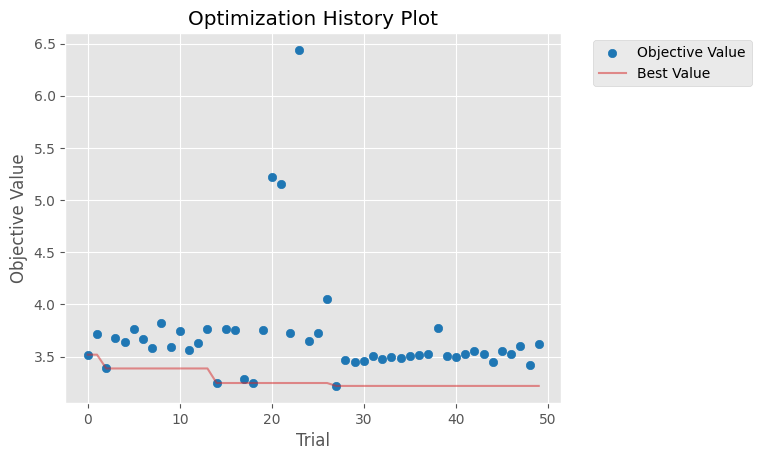

In [37]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study)
